https://www.kaggle.com/fournierp/captcha-version-2-images

The images are 5 letter words that can contain numbers. The images have had noise applied to them (blur and a line). They are 200 x 50 PNGs.

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np

# Loading the Dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) API Token"

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Captcha Slover/Dataset


In [ ]:
#!kaggle datasets download -d fournierp/captcha-version-2-images

In [ ]:
#!unzip 'captcha-version-2-images.zip'

# Inspecting the Dataset

Number of Images

In [ ]:
data_path = 'samples/samples'
len(os.listdir(path=data_path))

1070

Let's Look at Some Sample Image

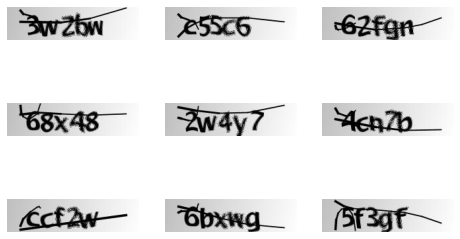

In [ ]:
images = os.listdir(data_path)
sample_images = images[-9:]
fig, ax = plt.subplots(3, 3, figsize=(8, 5))
for i in range(9):
  img = cv2.imread(str(data_path + '/' + sample_images[i]))
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')

# Data (Image Preprocessing) with OpenCV

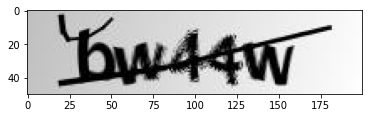

In [ ]:
first_img = cv2.imread(data_path + '/' + images[93])
plt.imshow(first_img)

Thresholding -> Black and White

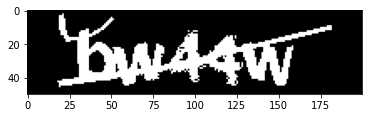

In [ ]:
ret, threshold = cv2.threshold(first_img, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshold, cmap='gray')

Reduce noise with median blue (see 'm' and 'x')

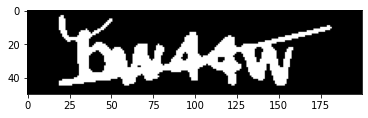

In [ ]:
blurred = cv2.medianBlur(threshold, 3)
plt.imshow(blurred, cmap='gray')

Remove the line that tranverses the image with erosion and dilation

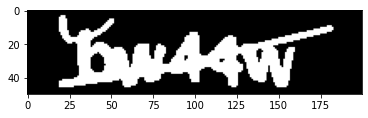

In [ ]:
kernel = np.ones([2, 2], np.uint8)
dilate1 = cv2.dilate(blurred, kernel, iterations=1)
plt.imshow(dilate1, cmap='gray')

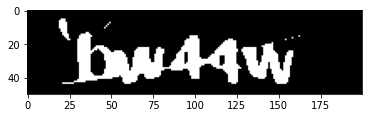

In [ ]:
kernel = np.ones([5, 1], np.uint8)
erode1 = cv2.erode(dilate1, kernel, iterations=1)
plt.imshow(erode1, cmap='gray')

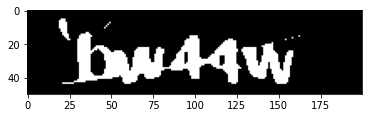

In [ ]:
kernel = np.ones([1, 1], np.uint8)
erode2 = cv2.erode(erode1, kernel, iterations=1)
plt.imshow(erode2, cmap='gray')

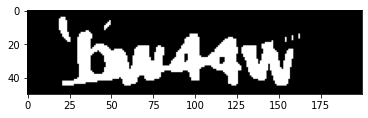

In [ ]:
kernel = np.ones([3, 1], np.uint8)
dilate2 = cv2.dilate(erode2, kernel, iterations=1)
plt.imshow(dilate2, cmap='gray')

Find Contours

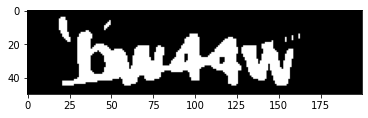

In [ ]:
binary = cv2.cvtColor(dilate2, cv2.COLOR_RGB2GRAY)
plt.imshow(binary, cmap='gray')

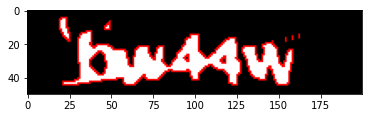

In [ ]:
contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
draw_contours = cv2.drawContours(cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB), contours, -1, (255, 0, 0), 1, cv2.LINE_4)
plt.imshow(draw_contours, cmap='gray')

Draw bounding box for each contour

In [ ]:
bounding_box = [cv2.boundingRect(contour) for contour in contours]


# Build and Train Model

References:

https://www.kaggle.com/vykstorm/extracting-words-from-images-with-opencv-part-2